In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.style.use('seaborn-v0_8')

#Series Temporales con redes LSTM. Multivariate Multi-Step

##1. El problema a resolver

Crear y entrenar una Red LSTM usando el enfoque multivariado + multi-step:

![](https://drive.google.com/uc?export=view&id=1DFiBn_up4iEcXyhO1s12DAgABDWHNlyb)

Se toma como entrada del modelo 16 covariables disponibles en el dataset (de ahí el término multivariado) y a la salida intentaremos predecir 3 horas de las 16 variables a futuro (de ahí el término multi-step).

Específicamente tendremos que modificar en nuestro código:

1. **El pre-procesamiento** para crear el dataset supervisado con el número de covariables requerido a la entrada del modelo
2. **La Red LSTM**, que en lugar de una sola ahora deberá aceptar 16 variables de entrada (cada una con un registro de 48 bloques de 30 minutos).

##2. Lectura del set de datos

La muestra de información corresponde al periodo del 01/mar/2023 al 31/jul/2023


In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Flatten, GRU
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
import tensorflow as tf


# df1 = pd.read_csv('cpu_percent_results_2.csv', usecols=['beginTimeSeconds', 'CPU percent'])
# df2 = pd.read_csv('uptime_results_2.csv', usecols=['Uptime'])
# df3 = pd.read_csv('tx_rx_results_2.csv',
#                   usecols=['Rx packets', 'Tx packets'])
# df4 = pd.read_csv('nb_np_results_2.csv',
#                   usecols=['NetBytes In', 'NetBytes Out', 'NetPackets In', 'NetPackets Out'])
# df5 = pd.read_csv('disk_memory_results_2.csv',
#                   usecols=['Disk read/s', 'Disk write/s', 'Free Disk', 'Free Memory', 'Used Disk',
#                            'Used Memory'], dtype='str')
# df6 = pd.read_csv('disk_percent_results_2.csv', usecols=['Disk Used percent'])
# df7 = pd.read_csv('memory_percent_results_2.csv', usecols=['Memory Used percent'])

# df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)
# df = df2.copy()
# df.head()

In [ ]:
df = pd.read_csv('data (1).csv', index_col=0, parse_dates=['beginTimeSeconds'])
df.head()

,CPU percent,Uptime,Rx packets,Tx packets,NetBytes In,NetBytes Out,NetPackets In,NetPackets Out,Disk read/s,Disk write/s,Free Disk,Free Memory,Used Disk,Used Memory,Disk Used percent,Memory Used percent
beginTimeSeconds,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,35.89,99.4234,1800,1800,15,15,15,15,14.12,44.97,76.93,3.75,43.86,4.44,27.57,54.23
2023-03-01 00:30:00,36.57,99.4233,1800,1800,15,15,15,15,5.19,41.19,76.94,3.76,43.84,4.43,27.55,54.14
2023-03-01 01:00:00,37.94,99.4232,1800,1800,15,15,15,15,23.64,70.99,77.00,3.77,43.78,4.41,27.52,53.91
2023-03-01 01:30:00,37.40,99.4231,1800,1800,15,15,15,15,5.25,38.45,77.00,3.78,43.79,4.41,27.52,53.86
2023-03-01 02:00:00,38.08,99.4230,1800,1800,15,15,15,15,9.42,43.94,77.01,3.76,43.77,4.43,27.51,54.11


In [ ]:
df.shape

(7344, 16)

In [ ]:
new_order_columns = [
    'Free Memory',
    'Used Memory',
    'Free Disk',
    'Used Disk',
    'Disk read/s',
    'Disk write/s',
    'NetBytes In',
    'NetBytes Out',
    'NetPackets In',
    'NetPackets Out',
    'Rx packets',
    'Tx packets',
    'CPU percent',
    'Memory Used percent',
    'Disk Used percent',
    'Uptime',
]
df = df[new_order_columns]

In [ ]:
# df['beginTimeSeconds'] = pd.to_datetime(df['beginTimeSeconds'], unit='s')
# df = df.set_index('beginTimeSeconds')

In [ ]:
df.shape # un total de 7344 datos con 16 variables

(7344, 16)

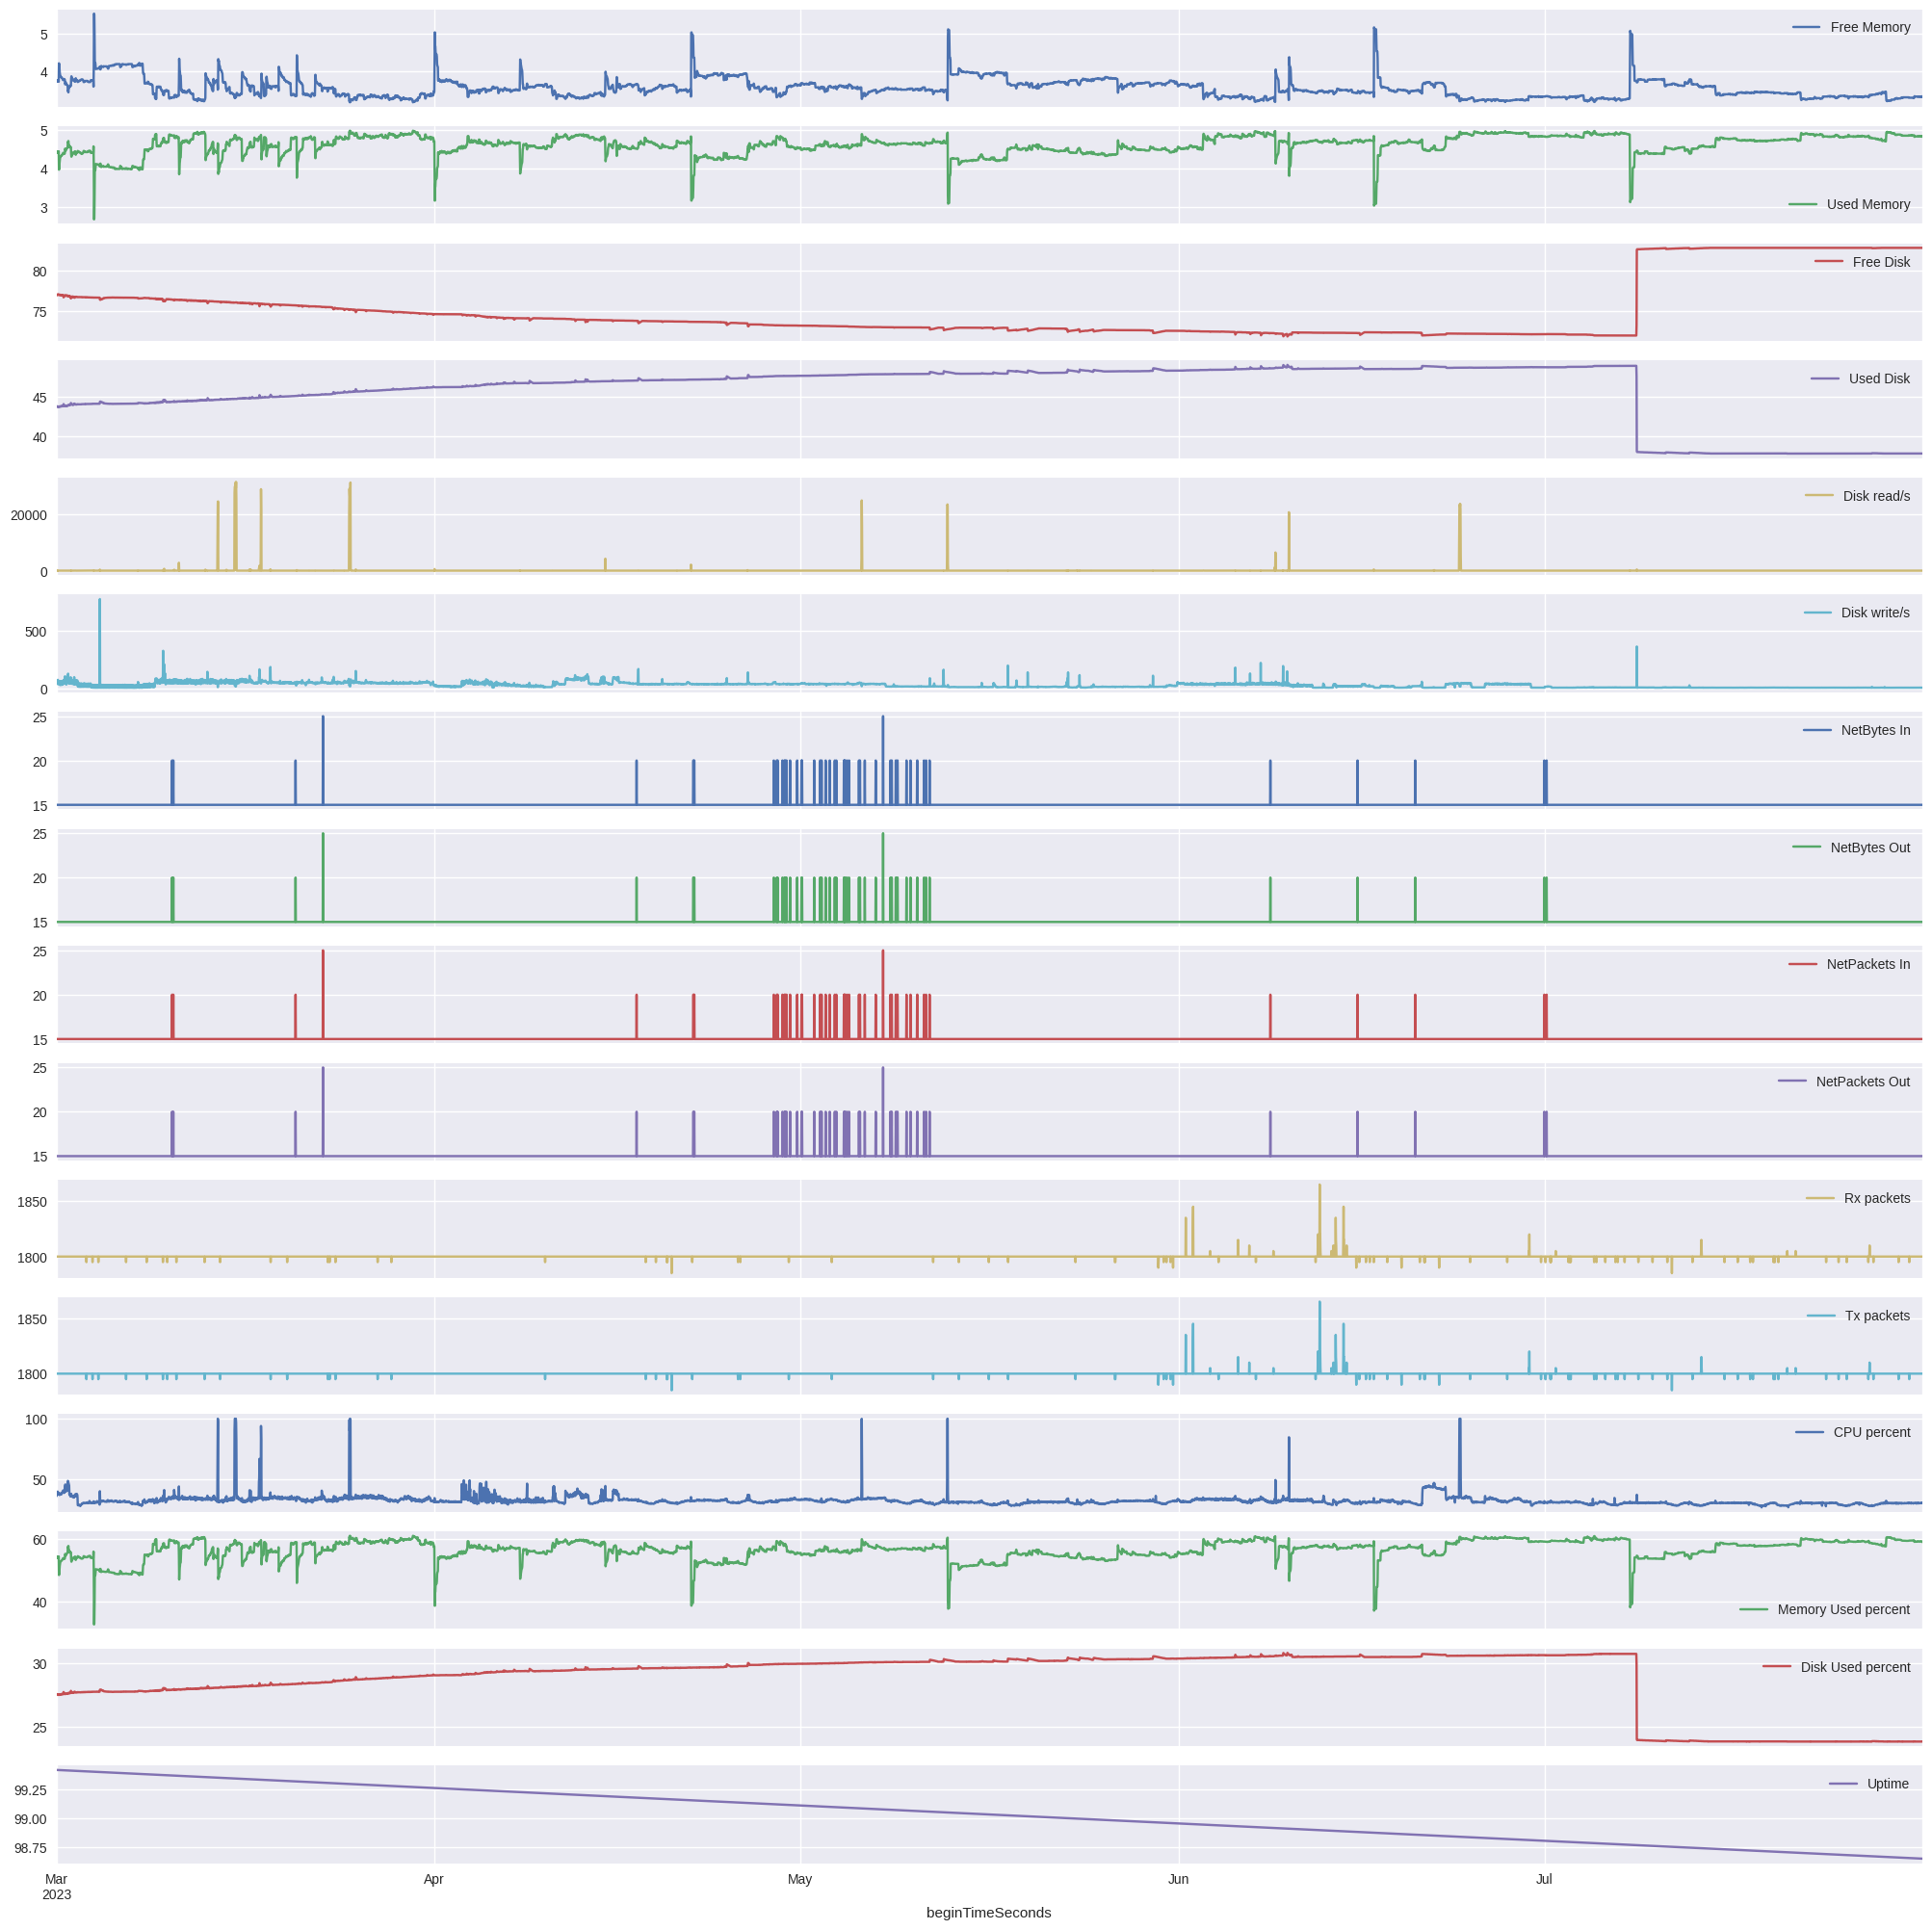

In [ ]:
cols = df.columns

# Dibujar la totalidad de registros
N = df.shape[0]       # Número de registros
plots = df[cols][:N] # Series de tiempo individuales
# plots.index = df['beginTimeSeconds'][0:N] # Variable tiempo
plots.index = df.index[:N] # Variable tiempo
_ = plots.plot(subplots=True, figsize=(25,25))

## 3. Gestión de características



Es necesario eliminar cierto segmento de la información debido a su carencia de temporalidad, puesto a que generaría errores durante el entrenamiento.
La información a predecir corresponde a los datos recolecados posterior al 5 de julio de 2023

In [ ]:
df = df[(df.index <= '2023-07-05 00:00:00')]

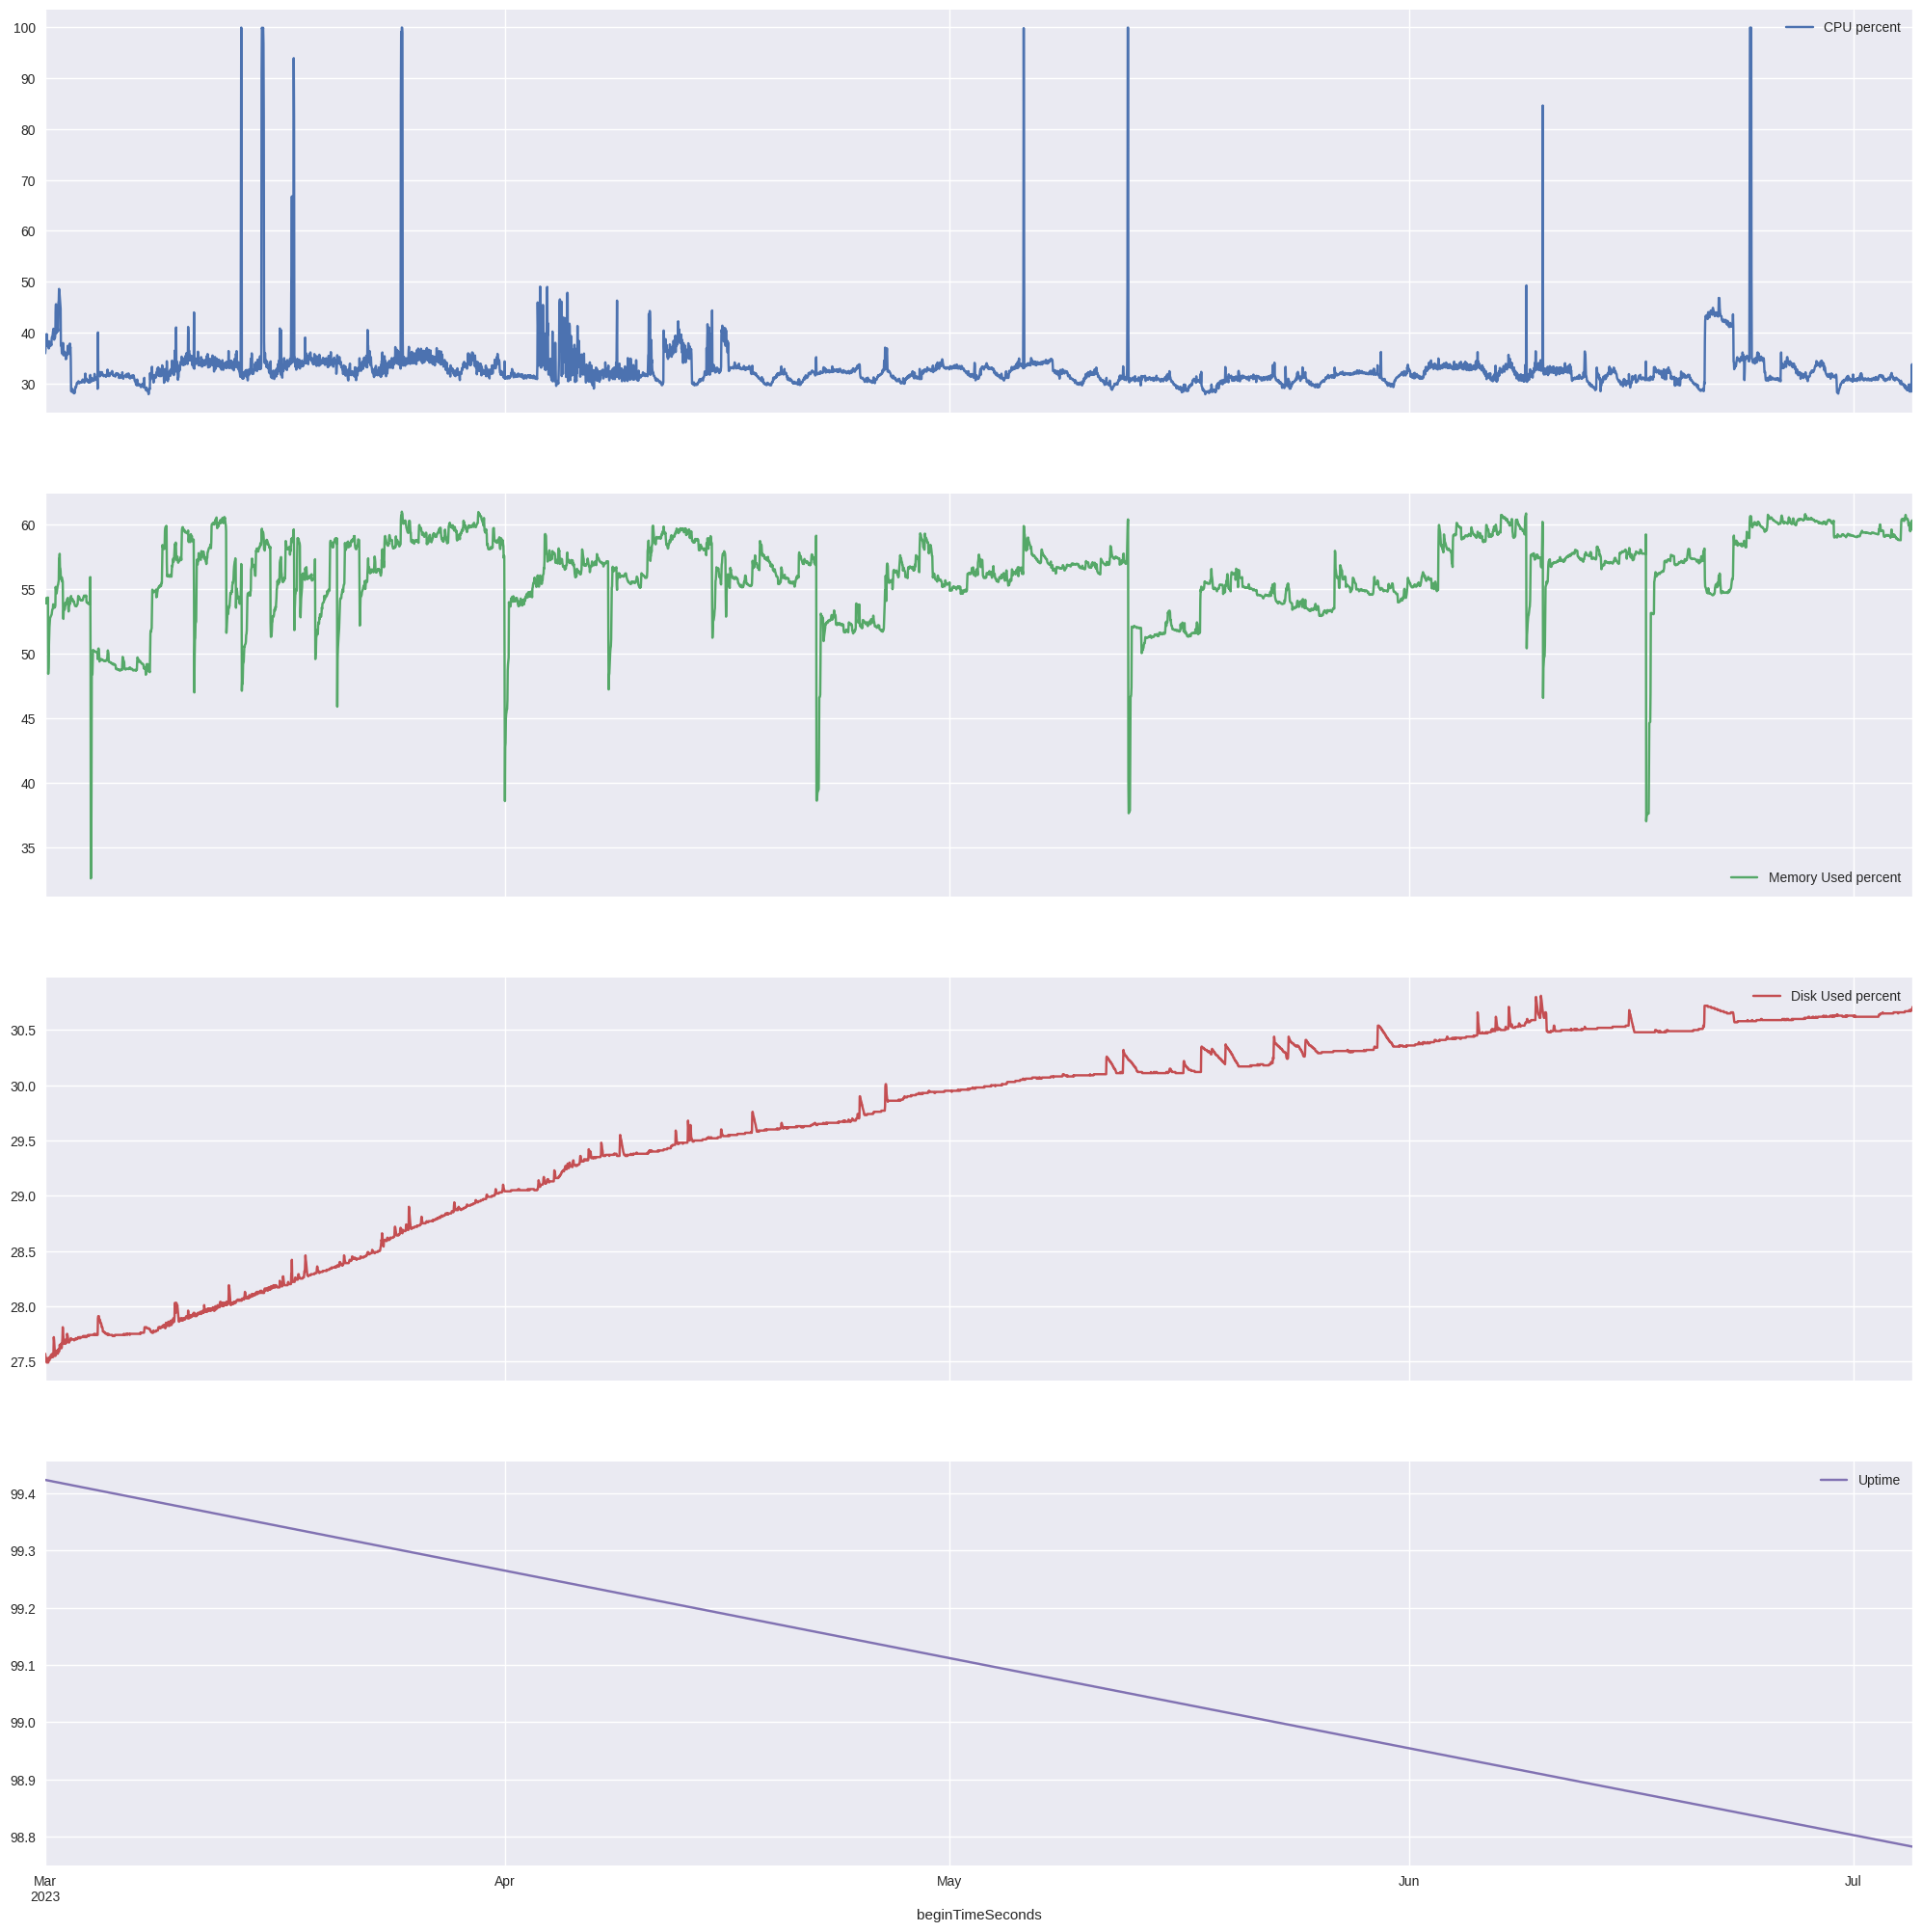

In [ ]:
cols = df.columns

# Dibujar la totalidad de registros
N = df.shape[0]       # Número de registros
plots = df[cols[-4:]][:N] # Series de tiempo individuales
# plots.index = df['beginTimeSeconds'][0:N] # Variable tiempo
plots.index = df.index[0:N] # Variable tiempo
_ = plots.plot(subplots=True, figsize=(25,25))

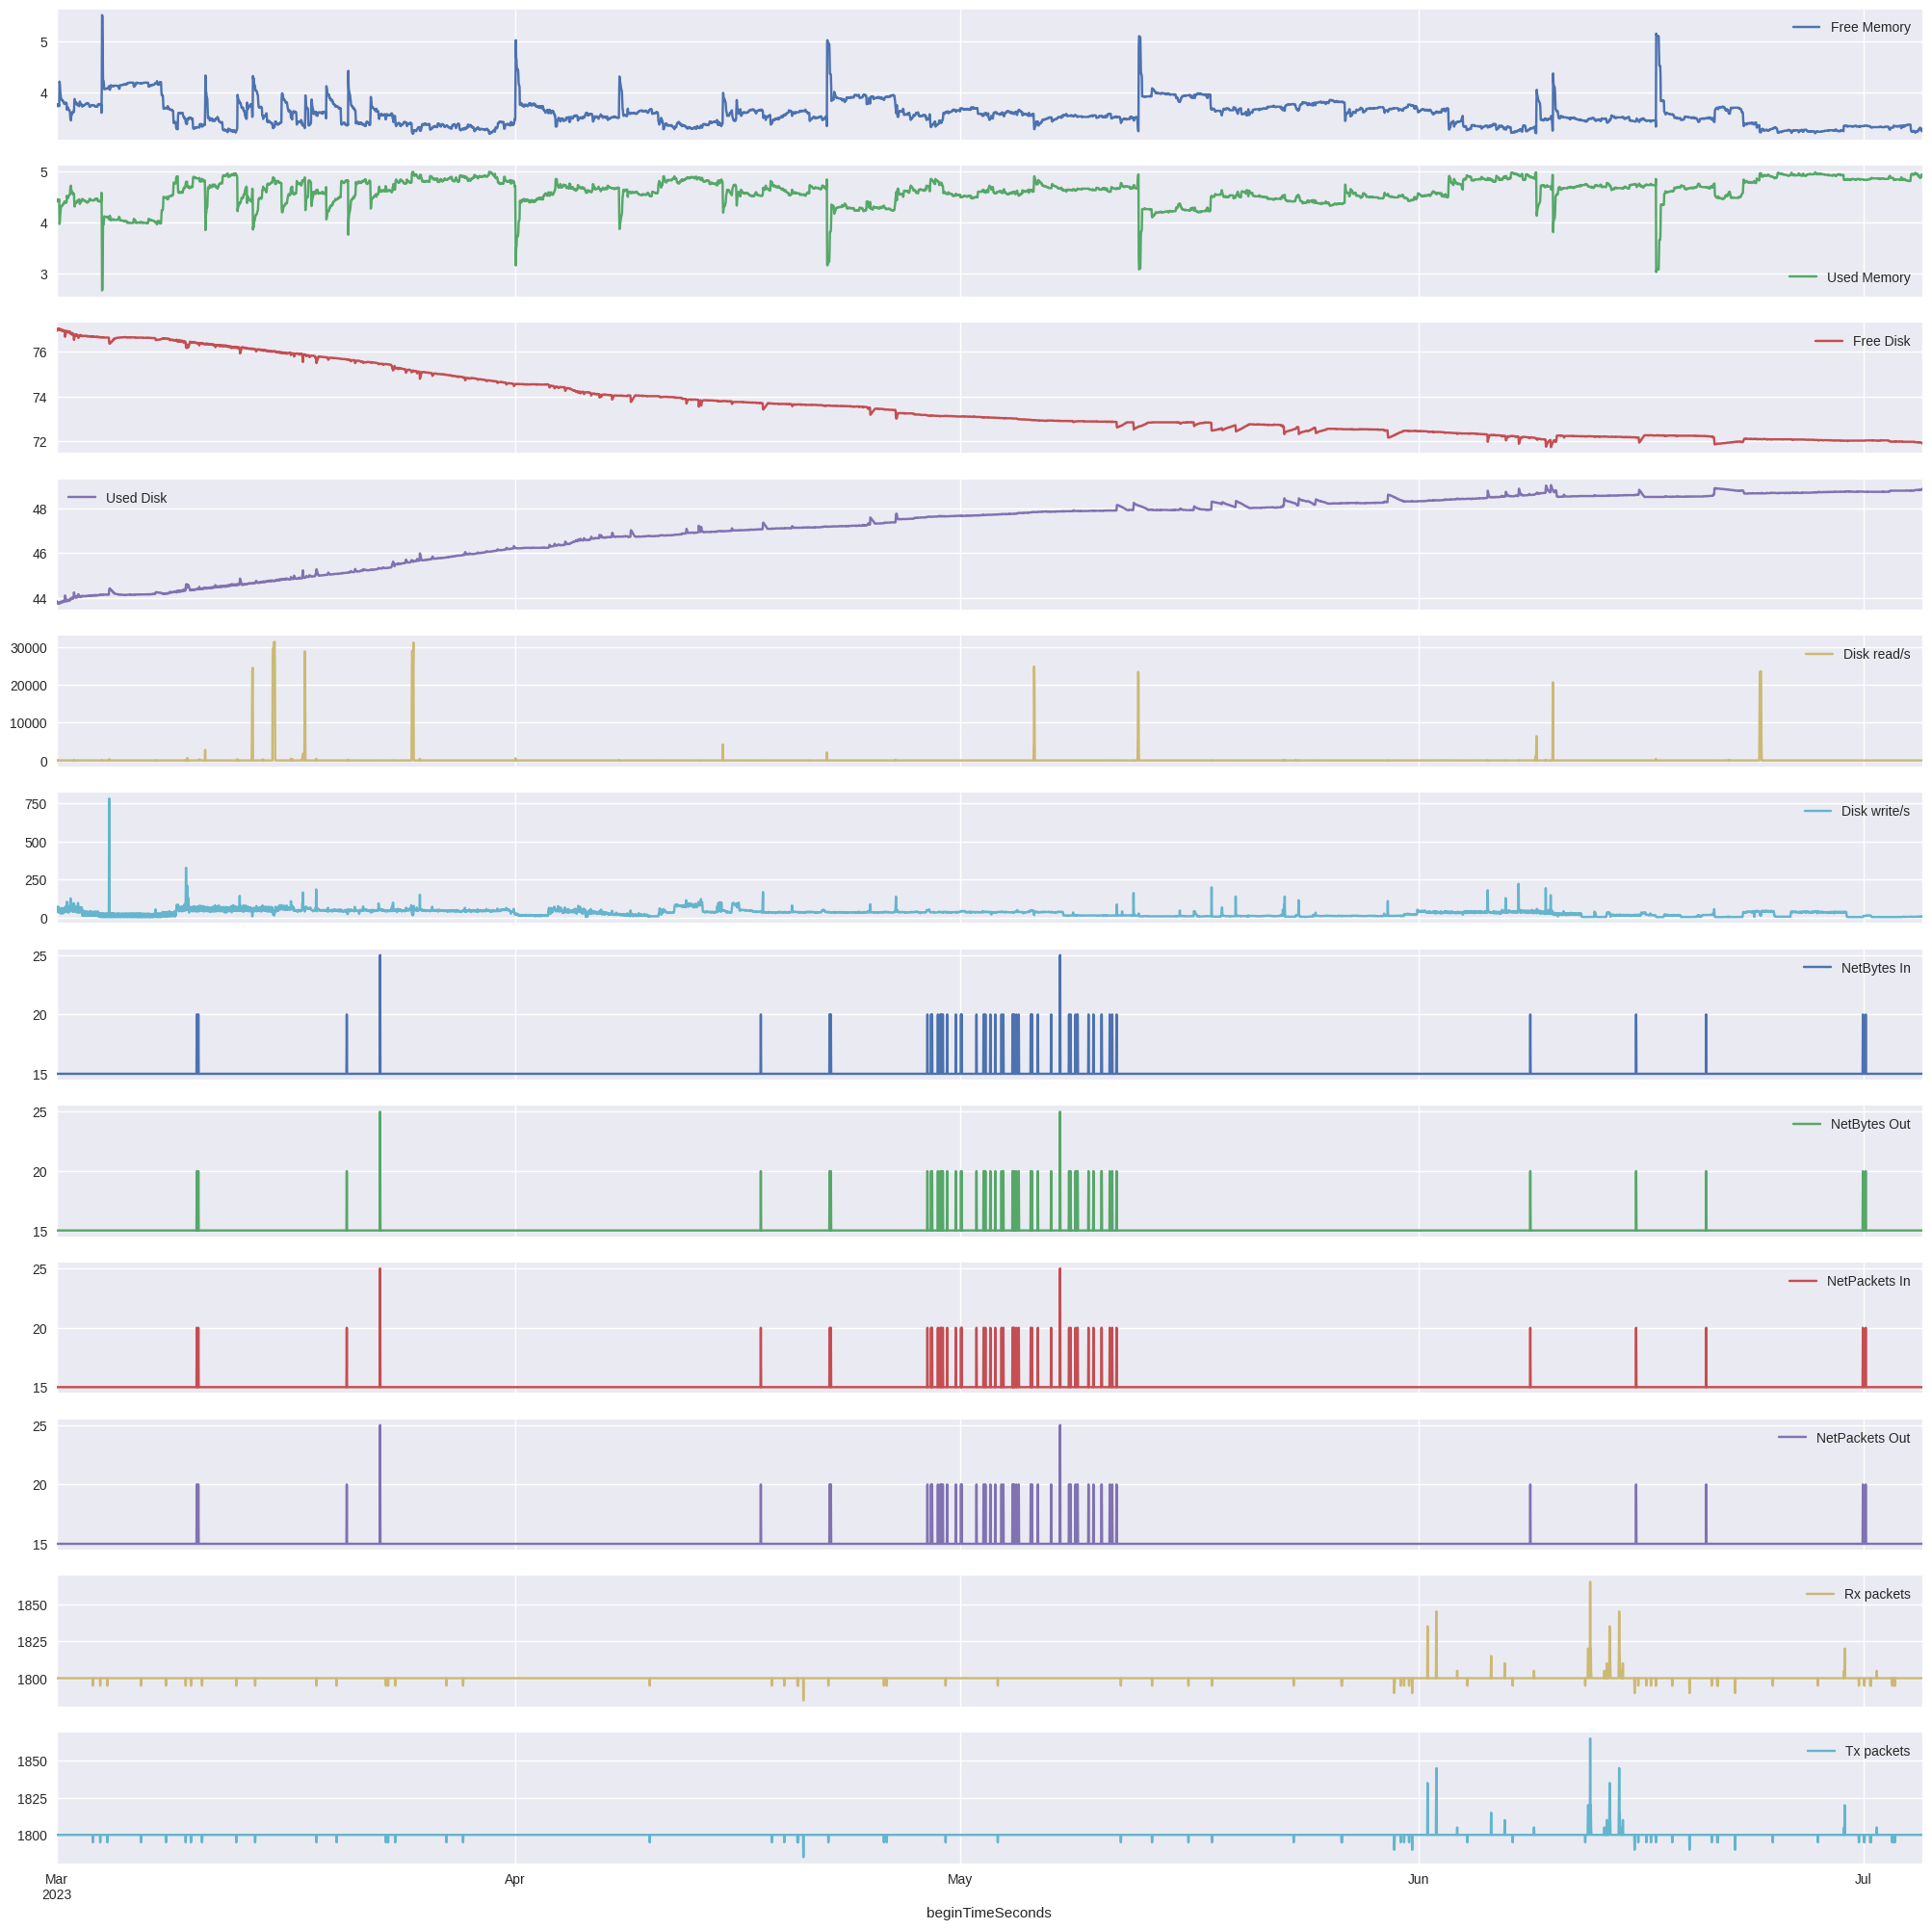

In [ ]:
cols = df.columns

# Dibujar la totalidad de registros
N = df.shape[0]       # Número de registros
plots = df[cols[:-4]][:N] # Series de tiempo individuales
# plots.index = df['beginTimeSeconds'][0:N] # Variable tiempo
plots.index = df.index[0:N] # Variable tiempo
_ = plots.plot(subplots=True, figsize=(25,25))

In [ ]:
df.shape

(6049, 16)

##3.1 Descripción

In [ ]:
for column in df.columns:
  print(f'\nVariable [{column}]\n', df[column].describe())


Variable [Free Memory]
 count    6049.000000
mean        3.586995
std         0.250336
min         3.200000
25%         3.400000
50%         3.550000
75%         3.700000
max         5.520000
Name: Free Memory, dtype: float64

Variable [Used Memory]
 count    6049.000000
mean        4.602232
std         0.250353
min         2.670000
25%         4.490000
50%         4.640000
75%         4.790000
max         4.990000
Name: Used Memory, dtype: float64

Variable [Free Disk]
 count    6049.000000
mean       73.601152
std         1.477678
min        71.740000
25%        72.350000
50%        73.060000
75%        74.550000
max        77.050000
Name: Free Disk, dtype: float64

Variable [Used Disk]
 count    6049.000000
mean       47.183316
std         1.477693
min        43.730000
25%        46.230000
50%        47.720000
75%        48.430000
max        49.050000
Name: Used Disk, dtype: float64

Variable [Disk read/s]
 count     6049.000000
mean       132.422352
std       1772.217510
min      

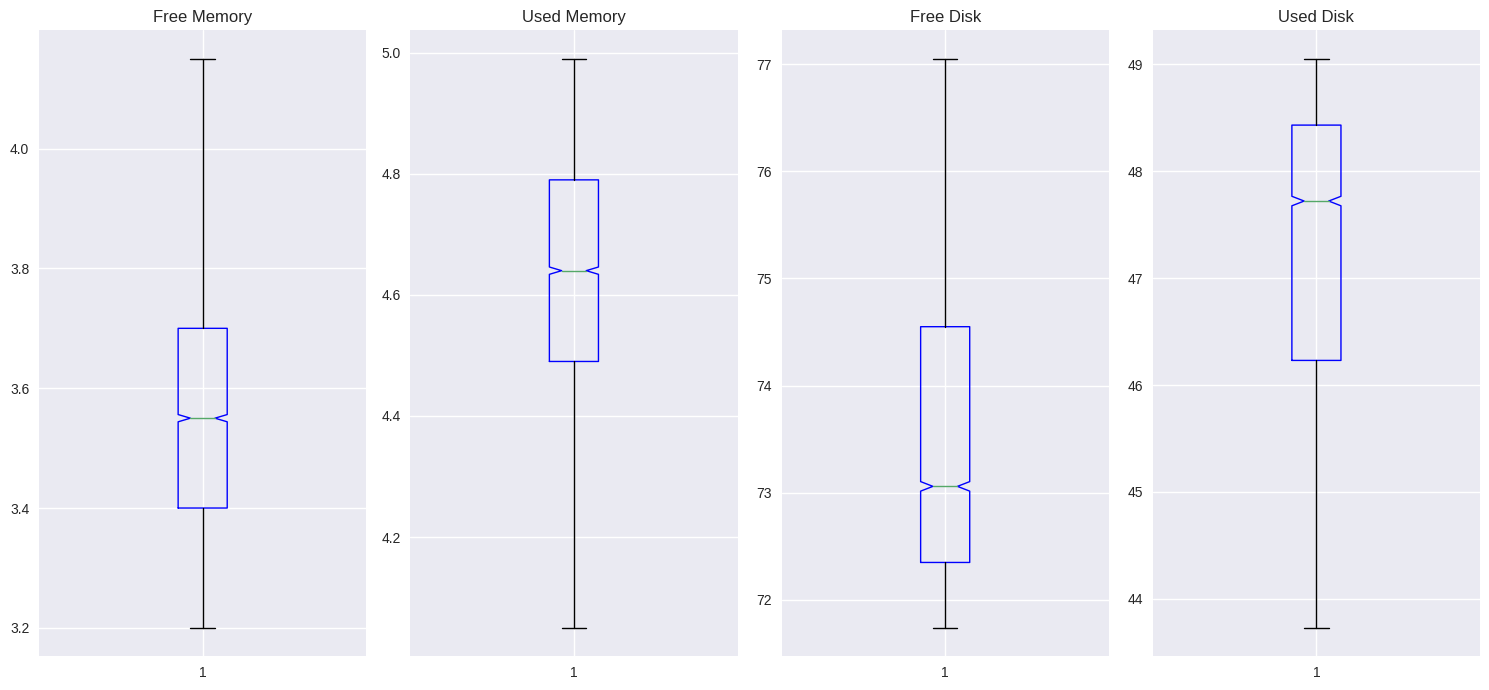

In [ ]:
draw_columns = df.columns
fig, axes = plt.subplots(1, len(draw_columns[:4]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[:4], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

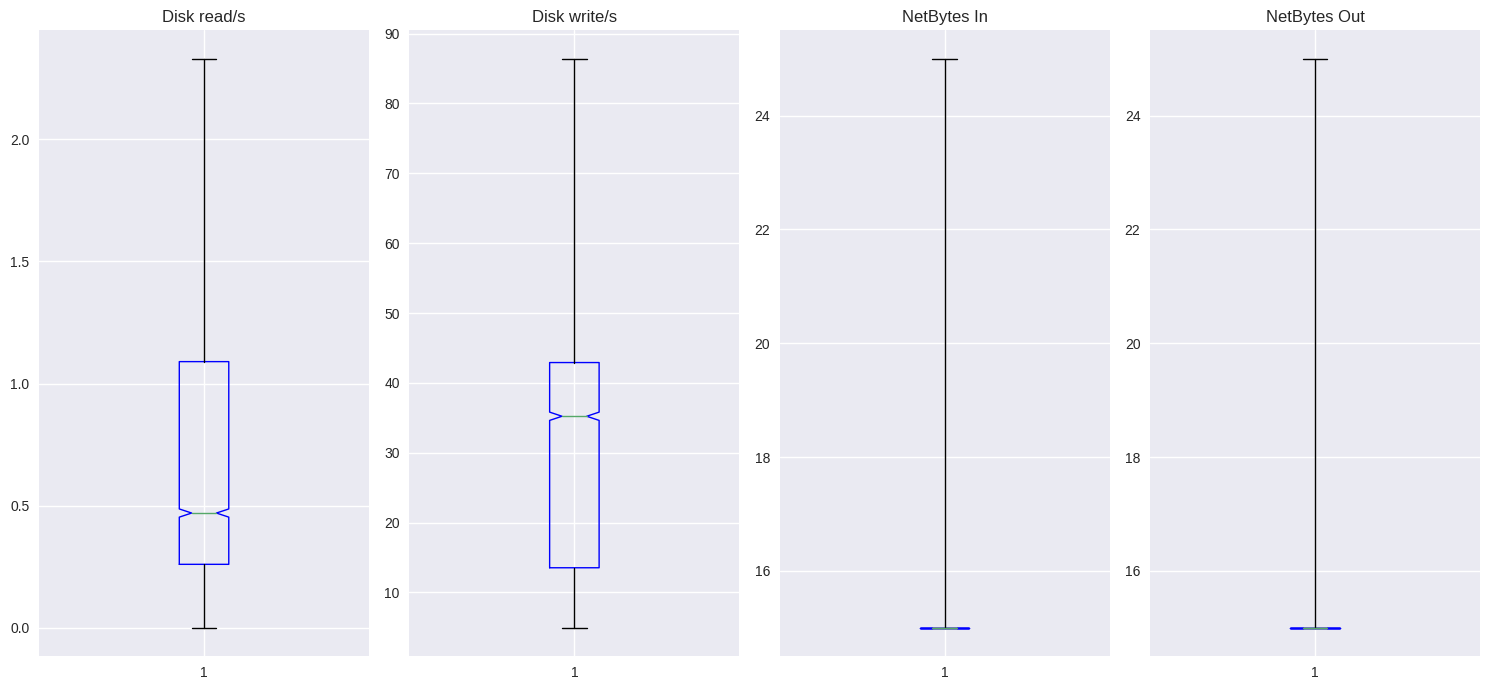

In [ ]:
fig, axes = plt.subplots(1, len(draw_columns[4:8]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[4:8], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

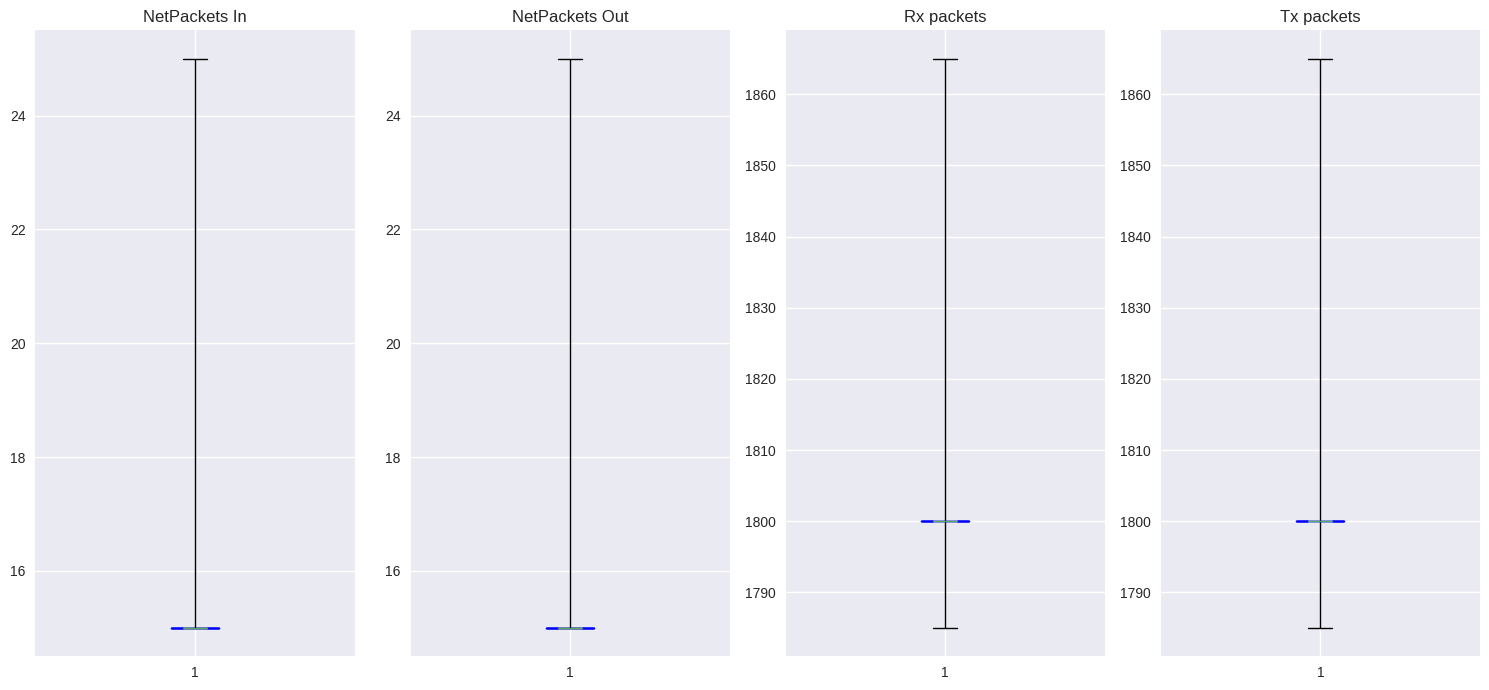

In [ ]:
fig, axes = plt.subplots(1, len(draw_columns[8:12]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[8:12], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

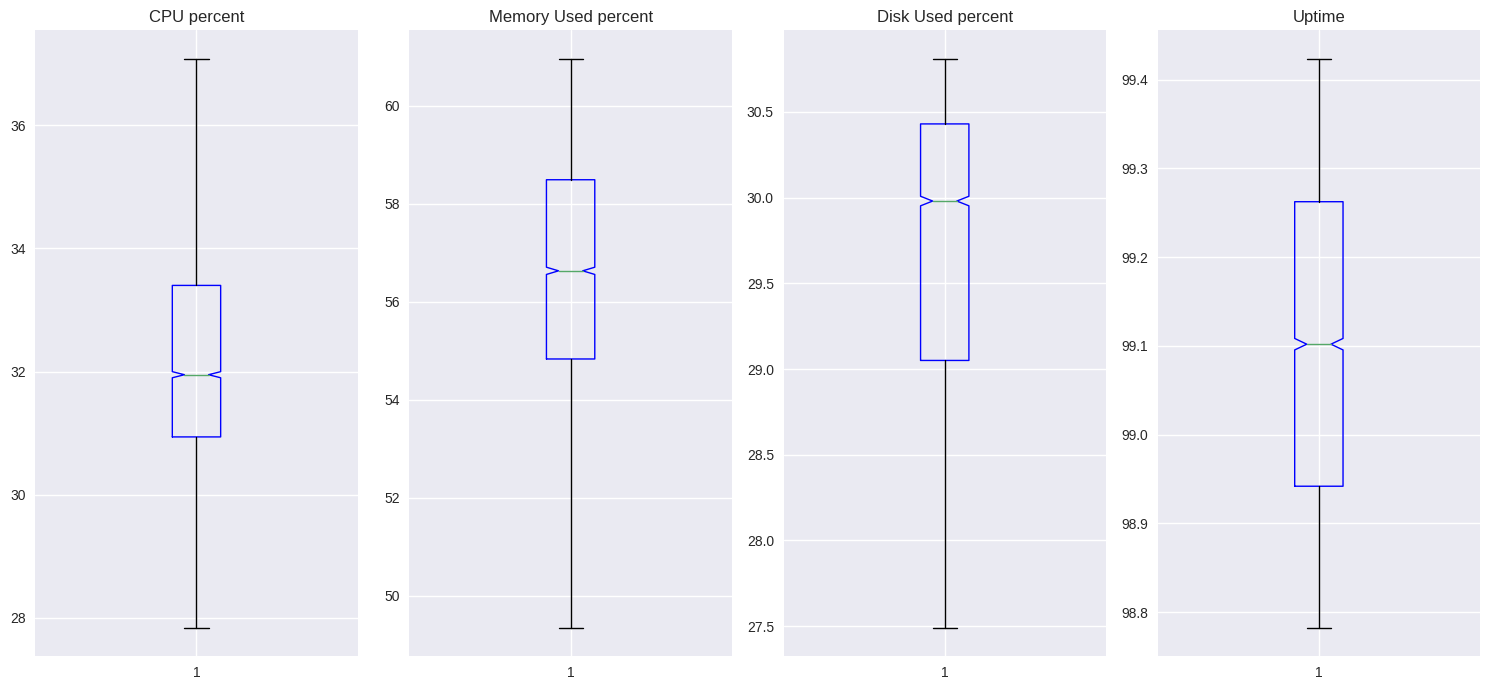

In [ ]:
fig, axes = plt.subplots(1, len(draw_columns[12:]),figsize =(15, 7))

for draw_column, axe in zip(draw_columns[12:], axes):
  box = axe.boxplot(df[draw_column], notch=True, vert=True, autorange=True, sym="")
  for box in box['boxes']:
    box.set_color('b')
    axe.set_title(draw_column)
plt.tight_layout()
plt.show()

## 3.2 Determinación de variabilidad


In [ ]:
print(len(df.columns))
for column in df.columns:
  arr = df[column].unique()
  print(f'Columna: [{column}] :: datos únicos [{arr}], Total de datos únicos [{len(arr)}]')

16
Columna: [Free Memory] :: datos únicos [[3.75 3.76 3.77 3.78 3.74 4.22 4.18 4.06 3.98 3.93 3.89 3.87 3.86 3.85
 3.83 3.82 3.81 3.79 3.8  3.67 3.68 3.71 3.72 3.7  3.66 3.64 3.63 3.5
 3.51 3.46 3.55 3.56 3.58 3.62 3.61 3.88 3.73 4.13 5.52 5.49 4.97 4.23
 4.15 4.07 4.08 4.09 4.1  4.14 4.16 4.17 4.19 4.2  4.12 4.21 3.97 3.95
 3.96 3.94 3.69 3.65 3.52 3.41 3.42 3.43 3.32 3.3  3.29 3.6  3.54 3.53
 3.48 3.4  3.39 3.49 3.31 3.33 3.38 3.36 3.37 3.34 3.35 4.34 4.01 4.
 3.9  3.47 3.45 3.44 3.28 3.27 3.26 3.25 3.24 3.23 3.92 3.84 3.57 4.33
 4.27 4.29 4.25 4.05 4.04 4.03 4.02 3.99 3.59 3.91 4.43 3.22 3.2  3.21
 5.03 4.69 4.66 4.51 4.48 4.47 4.45 4.39 4.32 5.02 5.01 4.98 4.96 4.95
 4.72 4.37 4.36 4.9  5.11 5.1  5.09 4.71 4.31 4.38 4.11 5.16 5.13 5.12
 4.81 4.54 4.53 4.35]], Total de datos únicos [144]
Columna: [Used Memory] :: datos únicos [[4.44 4.43 4.41 4.45 4.42 3.97 4.   4.13 4.2  4.26 4.3  4.32 4.33 4.34
 4.36 4.37 4.38 4.4  4.39 4.52 4.5  4.48 4.47 4.49 4.51 4.53 4.54 4.56
 4.69 4.68 4.72 

In [ ]:
# df['CPU percent'] = df['CPU percent'].round(2)
# df['Uptime'] = df['Uptime'].round(2)
# df['Disk read/s'] = df['Disk read/s'].apply(lambda x: round(float(x), 4))
# df['Disk write/s'] = df['Disk write/s'].apply(lambda x: round(float(x), 2))
# df['Disk Used percent'] = df['Disk Used percent'].round(2)
# df['Memory Used percent'] = df['Memory Used percent'].round(2)
# df['Free Memory'] = df['Free Memory'].apply(lambda x: round(float(x) / 1e9, 2))
# df['Free Disk'] = df['Free Disk'].apply(lambda x: round(float(x) / 1e9, 2))
# df['Used Disk'] = df['Used Disk'].apply(lambda x: round(float(x) / 1e9, 2))
# df['Used Memory'] = df['Used Memory'].apply(lambda x: round(float(x) / 1e9, 2))

In [ ]:
df.head()

,Free Memory,Used Memory,Free Disk,Used Disk,Disk read/s,Disk write/s,NetBytes In,NetBytes Out,NetPackets In,NetPackets Out,Rx packets,Tx packets,CPU percent,Memory Used percent,Disk Used percent,Uptime
beginTimeSeconds,,,,,,,,,,,,,,,,
2023-03-01 00:00:00,3.75,4.44,76.93,43.86,14.12,44.97,15,15,15,15,1800,1800,35.89,54.23,27.57,99.4234
2023-03-01 00:30:00,3.76,4.43,76.94,43.84,5.19,41.19,15,15,15,15,1800,1800,36.57,54.14,27.55,99.4233
2023-03-01 01:00:00,3.77,4.41,77.00,43.78,23.64,70.99,15,15,15,15,1800,1800,37.94,53.91,27.52,99.4232
2023-03-01 01:30:00,3.78,4.41,77.00,43.79,5.25,38.45,15,15,15,15,1800,1800,37.40,53.86,27.52,99.4231
2023-03-01 02:00:00,3.76,4.43,77.01,43.77,9.42,43.94,15,15,15,15,1800,1800,38.08,54.11,27.51,99.4230


### 3.3 Matriz de correlación

Se identifica la correlación de variables.
Una correlación mayor cuando lo valores son mas cercanos a -1 y 1.
Nos indica si las variables tienen impacto en la otra.

In [ ]:
correlation_matrix = df.corr()

# Mostrar la matriz de correlación
print('Matriz de correlación:')
print(correlation_matrix)

Matriz de correlación:
                     Free Memory  Used Memory  Free Disk  Used Disk  \
Free Memory             1.000000    -0.999943   0.213579  -0.213530   
Used Memory            -0.999943     1.000000  -0.213727   0.213678   
Free Disk               0.213579    -0.213727   1.000000  -0.999994   
Used Disk              -0.213530     0.213678  -0.999994   1.000000   
Disk read/s            -0.077635     0.077848   0.050975  -0.050963   
Disk write/s           -0.233031     0.233043   0.362643  -0.362723   
NetBytes In            -0.003741     0.003696  -0.023508   0.023575   
NetBytes Out           -0.003741     0.003696  -0.023508   0.023575   
NetPackets In          -0.003741     0.003696  -0.023508   0.023575   
NetPackets Out         -0.003741     0.003696  -0.023508   0.023575   
Rx packets             -0.018790     0.018873  -0.040164   0.040189   
Tx packets             -0.018790     0.018873  -0.040164   0.040189   
CPU percent            -0.146697     0.146768   0.1400

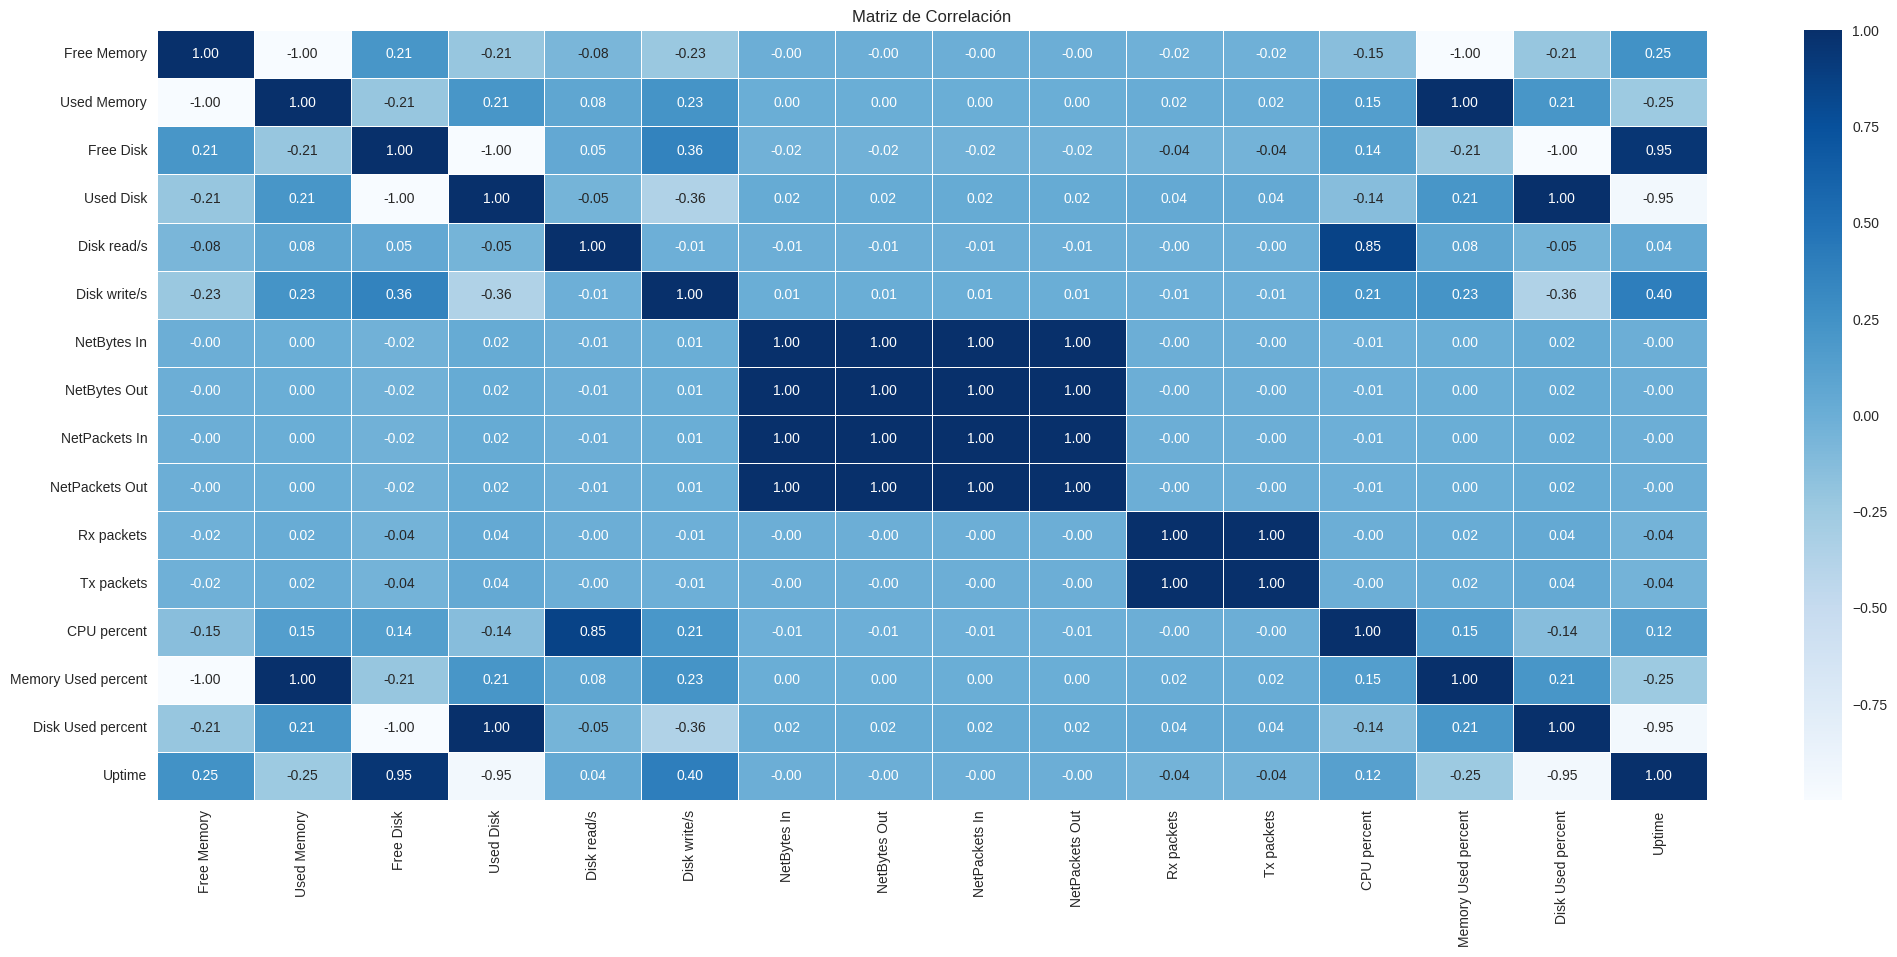

In [ ]:
import seaborn as sns

plt.figure(figsize=(25, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlación')
plt.show()

##4. Pre-procesamiento

Implica:

1. Partición en train/val/test 70%, 15%, 15%).
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento(Normalizar)

En cada una de estas fases se aplica el mismo código usado en los modelos univariados pero con algunas ligeras modificaciones.

### 4.1. Partición del set en entrenamiento, validación y prueba

A diferencia de otros modelos de Deep Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Nota:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

En este caso usaremos la misma función implementada para los modelos univariados con la diferencia de que en lugar de introducir una *serie* de Pandas, introduciremos el *DataFrame* completo.

Por tanto, la función retornará tres *dataframes* (train, val y test):

In [ ]:
data_length = df.shape[0]

train_percentaje = 0.7
validation_percentaje = 0.15
test_percentaje = 0.15

train_length, validation_length, test_length = data_length *train_percentaje, data_length * validation_percentaje, data_length * test_percentaje
train_length, validation_length, test_length

(4234.3, 907.35, 907.35)

In [ ]:
df.shape

(6049, 16)

In [ ]:
4235 + 907 + 907

6049

In [ ]:
dfr = df.reset_index()

In [ ]:
new_order_columns = [
    'Free Memory', # ok arq con droput
    'Used Memory', # ok arq con droput, se queda con el anterior grafico de test
    'Free Disk',
    'Used Disk', # ok
    'Disk read/s', # ok
    'Disk write/s', # ok
    'NetBytes In',
    'NetBytes Out',
    'NetPackets In',
    'NetPackets Out',
    'Rx packets',
    'Tx packets',
    'CPU percent', # ok
    'Memory Used percent', # ok
    'Disk Used percent', # ok
    'Uptime',
]

In [ ]:
col = 'Used Memory'

In [ ]:
dfr.loc[0:train_length, [col]]

,Used Memory
0,4.44
1,4.43
2,4.41
3,4.41
4,4.43
...,...
4231,4.50
4232,4.50
4233,4.50
4234,4.54


In [ ]:
# scaler = MinMaxScaler(feature_range=(-1,1))
# dfr = scaler.fit_transform(dfr[[col]])
# dfr

In [ ]:
# train_length = 4235
# validation_length = train_length + 907
# test_length = train_length + validation_length + 907

# tr_ds = df[0:train_length]
# val_ds = df[train_length:validation_length]
# ts_ds = df[validation_length:test_length]

# print(f'Tamaño subcojunto de entrenamiento: {tr_ds.shape}')
# print(f'Tamaño subcojunto de validación: {val_ds.shape}')
# print(f'Tamaño subcojunto de prueba: {ts_ds.shape}')

In [ ]:
train_length = 4235
validation_length = train_length + 907
test_length = train_length + validation_length + 907

tr_ds = df[0:train_length][[col]]
val_ds = df[train_length:validation_length][[col]]
ts_ds = df[validation_length:test_length][[col]]

print(f'Tamaño subcojunto de entrenamiento: {tr_ds.shape}')
print(f'Tamaño subcojunto de validación: {val_ds.shape}')
print(f'Tamaño subcojunto de prueba: {ts_ds.shape}')

Tamaño subcojunto de entrenamiento: (4235, 1)
Tamaño subcojunto de validación: (907, 1)
Tamaño subcojunto de prueba: (907, 1)


In [ ]:
pd.DataFrame(tr_ds)

,Used Memory
beginTimeSeconds,
2023-03-01 00:00:00,4.44
2023-03-01 00:30:00,4.43
2023-03-01 01:00:00,4.41
2023-03-01 01:30:00,4.41
2023-03-01 02:00:00,4.43
...,...
2023-05-28 03:00:00,4.49
2023-05-28 03:30:00,4.50
2023-05-28 04:00:00,4.50


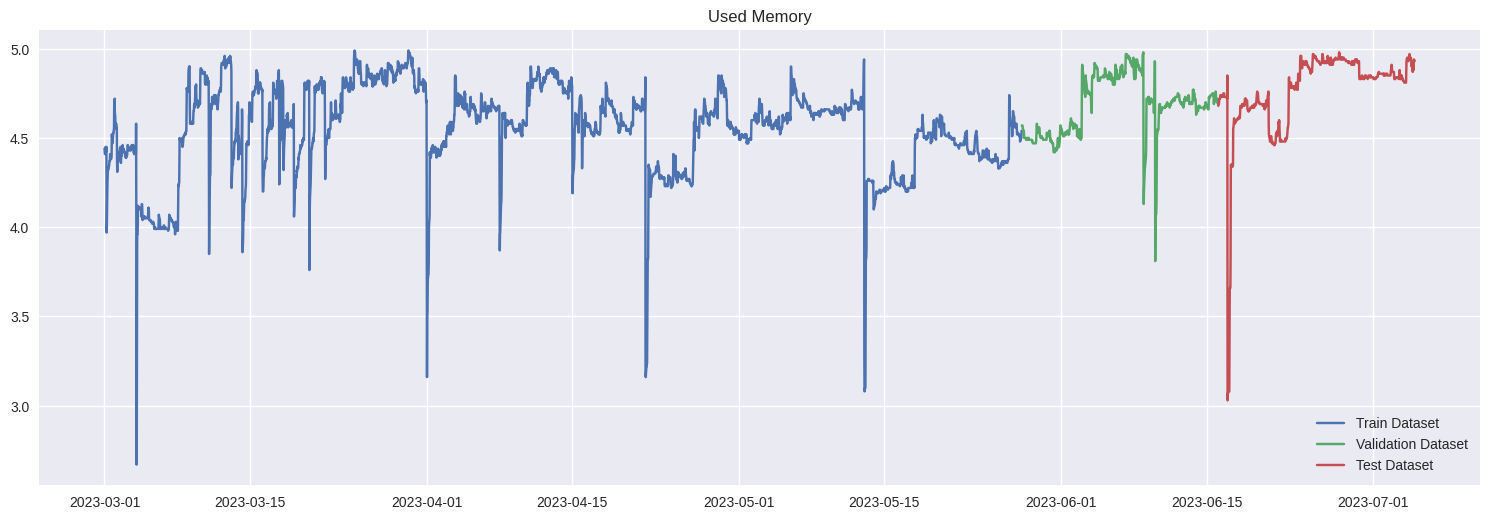

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)

plt.plot(tr_ds.index, tr_ds[col], label='Train Dataset')
plt.plot(val_ds.index, val_ds[col], label='Validation Dataset')
plt.plot(ts_ds.index, ts_ds[col], label='Test Dataset')
plt.title(col)
plt.legend()


plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_dataset.png')

plt.tight_layout()
plt.show()

In [ ]:
def create_supervised_dataset(dataset, input_length, output_length):
  X = []
  Y = []
  rows = dataset.shape[0]
  for i in range(rows - input_length - output_length + 1):
    X.append(dataset[i:i + input_length])
    Y.append(dataset[i + input_length:i + input_length + output_length])
  return np.array(X), np.array(Y)

In [ ]:
tr_ds.shape, val_ds.shape, ts_ds.shape

((4235, 1), (907, 1), (907, 1))

In [ ]:
# INPUT_LENGTH = 48    # Hiperparámetro
# OUTPUT_LENGTH = 6

# x_tr_ds, y_tr_ds = create_supervised_dataset(tr_ds, INPUT_LENGTH, OUTPUT_LENGTH)
# x_val_ds, y_val_ds = create_supervised_dataset(val_ds, INPUT_LENGTH, OUTPUT_LENGTH)
# x_ts_ds, y_ts_ds = create_supervised_dataset(ts_ds, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
INPUT_LENGTH = 48    # Hiperparámetro
OUTPUT_LENGTH = 6

x_tr_ds, y_tr_ds = create_supervised_dataset(tr_ds.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_val_ds, y_val_ds = create_supervised_dataset(val_ds.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts_ds, y_ts_ds = create_supervised_dataset(ts_ds.values, INPUT_LENGTH, OUTPUT_LENGTH)

In [ ]:
# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr_ds.shape}, y_tr: {y_tr_ds.shape}')
print(f'Set de validación - x_vl: {x_val_ds.shape}, y_vl: {y_val_ds.shape}')
print(f'Set de prueba - x_ts: {x_ts_ds.shape}, y_ts: {y_ts_ds.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (4234, 1, 1), y_tr: (4234, 1, 1)
Set de validación - x_vl: (906, 1, 1), y_vl: (906, 1, 1)
Set de prueba - x_ts: (906, 1, 1), y_ts: (906, 1, 1)


In [ ]:
4182 + 48 + 6

4236

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})

    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr_ds[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts_ds[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_val_ds[:,:,i])

    y_tr_s[:,:,0] = scalers[-1].fit_transform(y_tr_ds[:,:,0])
    y_vl_s[:,:,0] = scalers[-1].transform(y_val_ds[:,:,0])
    y_ts_s[:,:,0] = scalers[-1].transform(y_ts_ds[:,:,0])


    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers

In [ ]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr_ds, 'y_tr': y_tr_ds,
    'x_vl': x_val_ds, 'y_vl': y_val_ds,
    'x_ts': x_ts_ds, 'y_ts': y_ts_ds,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scalers = escalar_dataset(data_in,)

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

In [ ]:
x_tr_s.shape, y_tr_s.shape, x_vl_s.shape, y_vl_s.shape, x_ts_s.shape, y_ts_s.shape

((4234, 1, 1),
 (4234, 1, 1),
 (906, 1, 1),
 (906, 1, 1),
 (906, 1, 1),
 (906, 1, 1))

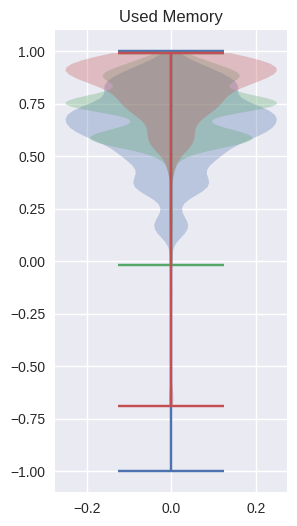

In [ ]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)
plt.figure(figsize=(3, 6))

plt.subplot(1, 1, 1)
plt.violinplot(dataset=x_tr_s[:,:,0].flatten(), positions=[0])
plt.violinplot(dataset=x_vl_s[:,:,0].flatten(), positions=[0])
plt.violinplot(dataset=x_ts_s[:,:,0].flatten(), positions=[0])
plt.title(col)

plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_frecuencia.png')
plt.show()

In [ ]:
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError, MeanSquaredError

In [ ]:
class MeanAbsoluteScaledError(tf.keras.metrics.Metric):
    def __init__(self, name='mean_absolute_scaled_error', **kwargs):
        super(MeanAbsoluteScaledError, self).__init__(name=name, **kwargs)
        self.mae = MeanAbsoluteError()
        self.mse = RootMeanSquaredError()

        # State variables
        self.total_mae = self.add_weight('total_mae', initializer='zeros')
        self.total_mse = self.add_weight('total_mse', initializer='zeros')
        self.count = self.add_weight('count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        mae = self.mae(y_true, y_pred)
        mse = self.mse(y_true, y_pred)

        # Avoid division by zero
        denominator = tf.where(tf.not_equal(mae, 0.0), mae, 1.0)

        # Update state variables
        self.total_mae.assign_add(tf.reduce_sum(mae))
        self.total_mse.assign_add(tf.reduce_sum(mse))
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        scaled_error = self.total_mse / self.total_mae
        return scaled_error

    def reset_states(self):
        # Reset state at the end of each epoch or at the start of training
        self.total_mae.assign(0.0)
        self.total_mse.assign(0.0)
        self.count.assign(0.0)

In [ ]:
np.expand_dims(x_tr_ds[:,:,0], -1).shape

(4234, 1, 1)

In [ ]:
64, 64 * 2, 64 * 4, 64 * 6, 64 * 8

(64, 128, 256, 384, 512)

In [ ]:
512 / 16

32.0

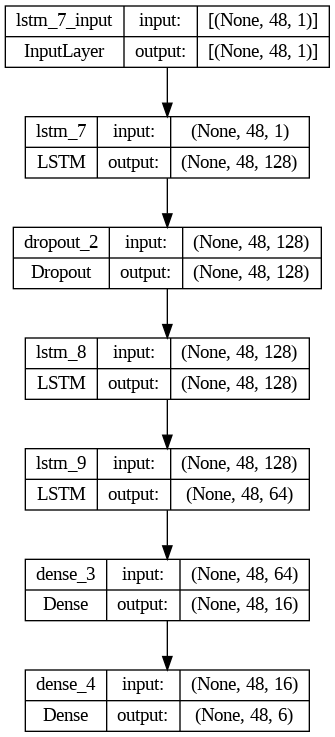

In [ ]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Flatten, Conv1D, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, Adagrad
from keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 512 # Tamaño del estado oculto (h) y de la celda de memoria (c)
# INPUT_SHAPE = (x_tr_ds.shape[1], 1) # 24 (horas) x 1 (feature)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

model = Sequential([
    # Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=INPUT_SHAPE), ####
    LSTM(128, input_shape=(48, 1), return_sequences = True,),
    # Bidirectional(LSTM(128, return_sequences = True,)),
    # LSTM(128, return_sequences = True,),
    Dropout(0.1),
    # Bidirectional(LSTM(128, return_sequences = True)),
    LSTM(128, return_sequences = True),
    # Dropout(0.3),
    # Bidirectional(LSTM(64, return_sequences = False)),
    LSTM(64, return_sequences = True),
    # Dropout(0.3),
    # LSTM(64, return_sequences = False),
    # Dropout(0.2),
    # LSTM(50),
    # Dropout(0.2),
    # Flatten(),

    # Dense(64, activation='sigmoid'),
    # Dropout(0.2),
    Dense(16, activation='relu'),
    # Dropout(0.3),
    # Dense(16, activation='relu'), ####
    # Dropout(0.3),
    # Dense(8, activation='relu'), ####
    # Dropout(0.2),
    Dense(6, activation='linear')])


plot_model(model, to_file='modelo.png', show_shapes=True, show_layer_names=True)

In [ ]:
# [model.compile(optimizer = RMSprop(learning_rate=5e-5), loss = root_mean_squared_error, metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(), MeanAbsoluteScaledError()]) for model in models]
model.compile(optimizer = RMSprop(5e-4), loss = 'mean_squared_error', metrics = [MeanAbsoluteError(), MeanAbsolutePercentageError(), MeanAbsoluteScaledError()])

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 200 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro

stories = model.fit(
    x = np.expand_dims(x_tr_s[:,:,0], axis=-1),
    y = np.expand_dims(y_tr_s[:,:,0], axis=-1),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (np.expand_dims(x_vl_s[:,:,0], axis=-1), np.expand_dims(y_vl_s[:,:,0], axis=-1)),
    verbose=2,
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)]
  )

In [ ]:
x_tr_s.shape, y_tr_s.shape, x_vl_s.shape, y_vl_s.shape, x_ts_s.shape, y_ts_s.shape

((4234, 1, 1),
 (4234, 1, 1),
 (906, 1, 1),
 (906, 1, 1),
 (906, 1, 1),
 (906, 1, 1))

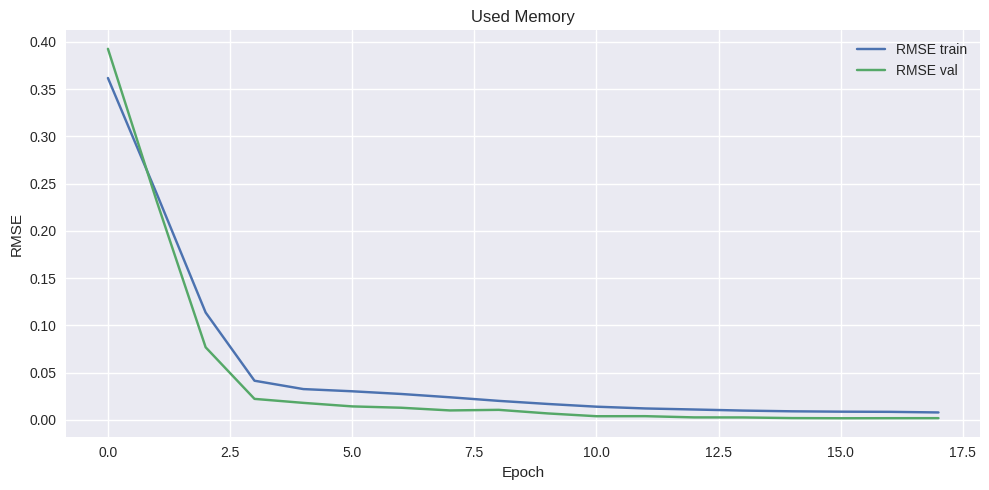

In [ ]:
# Graficar curvas de entrenamiento y validación
# para verificar que no existe overfitting
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.plot(stories.history['loss'], label='RMSE train')
plt.plot(stories.history['val_loss'],label='RMSE val')
plt.title(col)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend();

plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_mrse.png')
plt.tight_layout()
plt.show()

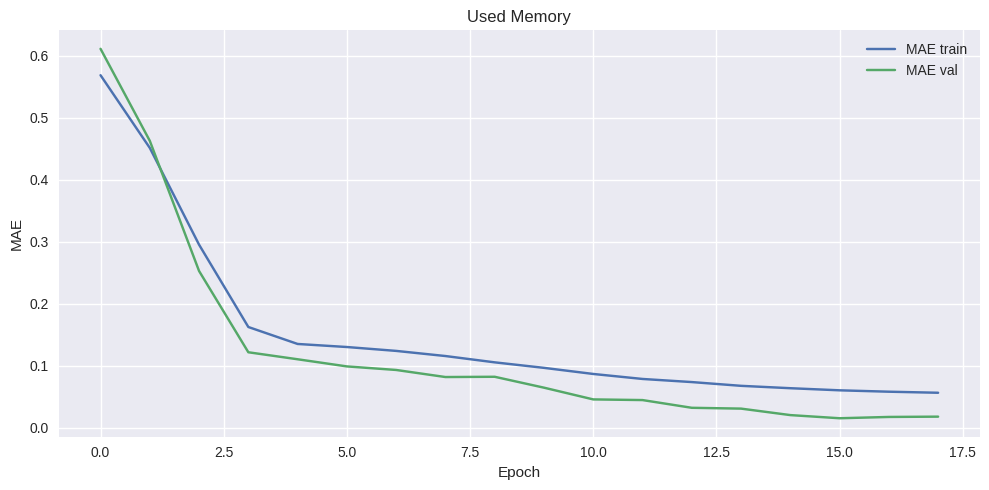

In [ ]:
# Graficar curvas de entrenamiento y validación
# para verificar que no existe overfitting
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.plot(stories.history['mean_absolute_error'], label='MAE train')
plt.plot(stories.history['val_mean_absolute_error'],label='MAE val')
plt.title(col)
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend();

plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_mae.png')
plt.tight_layout()
plt.show()

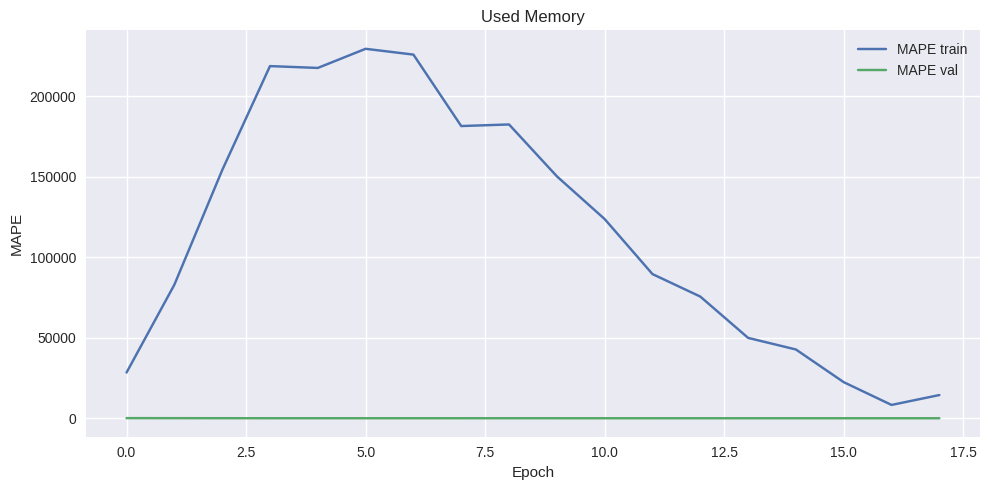

In [ ]:
# Graficar curvas de entrenamiento y validación
# para verificar que no existe overfitting
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.plot(stories.history['mean_absolute_percentage_error'], label='MAPE train')
plt.plot(stories.history['val_mean_absolute_percentage_error'],label='MAPE val')
plt.title(col)
plt.xlabel('Epoch')
plt.ylabel('MAPE')
plt.legend();

plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_mape.png')
plt.tight_layout()
plt.show()

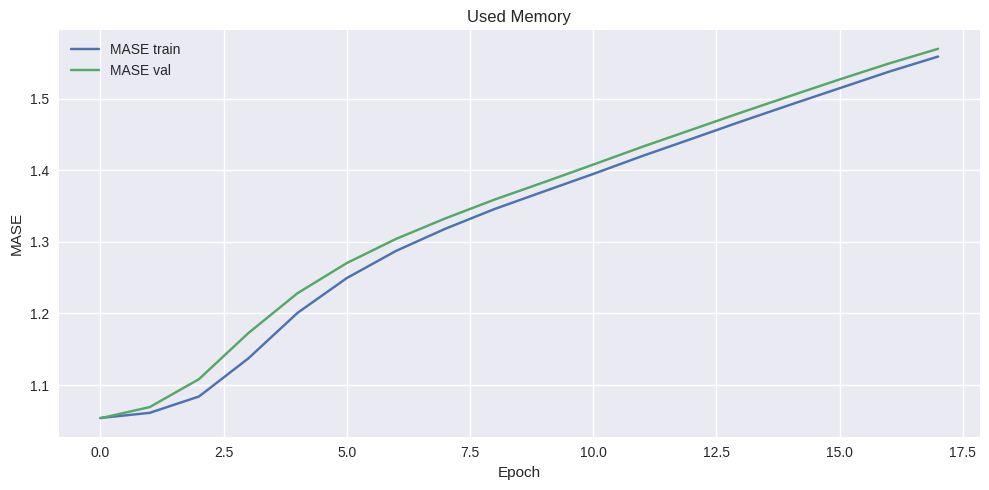

In [ ]:
# Graficar curvas de entrenamiento y validación
# para verificar que no existe overfitting
plt.figure(figsize=(10, 5))
plt.subplot(1, 1, 1)
plt.plot(stories.history['mean_absolute_scaled_error'], label='MASE train')
plt.plot(stories.history['val_mean_absolute_scaled_error'],label='MASE val')
plt.title(col)
plt.xlabel('Epoch')
plt.ylabel('MASE')
plt.legend();

plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_mase.png')
plt.tight_layout()
plt.show()

In [ ]:
model.save(f'{col.replace("/", "_")}_univariado_multistep.keras')

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 1, 128)            66560     
                                                                 
 dropout_29 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_40 (LSTM)              (None, 1, 128)            131584    
                                                                 
 dropout_30 (Dropout)        (None, 1, 128)            0         
                                                                 
 lstm_41 (LSTM)              (None, 1, 64)             49408     
                                                                 
 dropout_31 (Dropout)        (None, 1, 64)             0         
                                                                 
 dense_27 (Dense)            (None, 1, 16)           

In [ ]:
# y_pred_ts = np.array([model.predict(np.expand_dims(x_ts_ds[:,:,index], -1), verbose=0) for index in range(1)])

In [ ]:
y_pred_ts = np.array([model.predict(np.expand_dims(x_ts_s[:,:,index], -1), verbose=0) for index in range(1)])[0,:,:,0]

In [ ]:
y_pred_ts.shape, y_ts_ds.shape

((906, 1), (906, 1, 1))

In [ ]:
np.array([[1],[2]]).shape

(2, 1)

In [ ]:
scalers[0].inverse_transform([[1],[2]])

array([[4.99],
       [6.15]])

In [ ]:
y_pred_ts = np.transpose(y_pred_ts, (1,2,0))

In [ ]:
y_pred_ts.shape

(1, 1, 906)

In [ ]:
y_ts_ds.shape

(906, 1, 1)

In [ ]:
# scalers[0].inverse_transform(y_pred_ts[:, :, 0])[-1, :], y_ts[-1, :, 0]

In [ ]:
def predecir(x, model, scalers):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scalers: escaladores (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x, verbose=0)

    # return 1, y_pred_s

    for index, scaler in enumerate(scalers):
      y_pred_s[:,:,index] = scaler.inverse_transform(y_pred_s[:,:,index])

    rows, instances, cols = y_pred_s.shape
    ordered_list = np.zeros((instances,cols,rows))
    for i in range(len(y_pred_s)):
      for coldim in range(y_pred_s.shape[1]):
        for tdim in range(y_pred_s.shape[2]):
          ordered_list[coldim,tdim,i] = y_pred_s[i,coldim,tdim]
    return ordered_list


def predecir_3(x_ds, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scalers: escaladores (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    return np.expand_dims(scaler.inverse_transform(model.predict(np.expand_dims(x_ds[:,:,0], -1), verbose=0)), -1)

    return np.transpose(y_pred_s, (1,2,0))


def predecir_2(x_ds, model, scalers):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scalers: escaladores (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    result = model.predict(np.expand_dims(x_ds[:,:,0], -1), verbose=0)[:,:,0]
    print(result.shape)
    return np.expand_dims(scalers[0].inverse_transform(result), -1)

    return np.transpose(y_pred_s, (1,2,0))

In [ ]:
# # Calcular predicciones sobre el set de prueba
# y_tr_predict = predecir_3(x_tr_ds, model, scaler)
# y_vl_predict = predecir_3(x_val_ds, model, scaler)
# y_ts_predict = predecir_3(x_ts_ds, model, scaler)

In [ ]:
# y_tr_ds = scaler.inverse_transform(y_tr_ds[:,:,0])
# y_val_ds = scaler.inverse_transform(y_val_ds[:,:,0])
# y_ts_ds = scaler.inverse_transform(y_ts_ds[:,:,0])

In [ ]:
# y_tr_ds = np.expand_dims(y_tr_ds, -1)
# y_val_ds = np.expand_dims(y_val_ds, -1)
# y_ts_ds = np.expand_dims(y_ts_ds, -1)

In [ ]:
# Calcular predicciones sobre el set de prueba
y_tr_predict = predecir_2(x_tr_s, model, scalers)
y_vl_predict = predecir_2(x_vl_s, model, scalers)
y_ts_predict = predecir_2(x_ts_s, model, scalers)

(4234, 1)
(906, 1)
(906, 1)


In [ ]:
y_ts_predict.shape, y_vl_predict.shape, y_tr_predict.shape, y_tr_ds.shape

((906, 1, 1), (906, 1, 1), (4234, 1, 1), (4234, 1, 1))

In [ ]:
y_tr_ds.shape

(4234, 1, 1)

In [ ]:
# mae = MeanAbsoluteError()
# mape = MeanAbsolutePercentageError()
# mase = MeanAbsoluteScaledError()
# mae.update_state(y_tr_ds[:, :, 0], y_tr_predict[:, :, 0])
# mape.update_state(y_tr_ds[:, :, 0], y_tr_predict[:, :, 0])
# mase.update_state(y_tr_ds[:, :, 0], y_tr_predict[:, :, 0])

# with open('results_trdd.txt', 'a') as file:
#   file.write(f'VARIABLE ==> [{column}]\n')
#   file.write(f'RMSE -> {round(root_mean_squared_error(y_tr_ds[:, :, 0], y_tr_predict[:, :, 0]).numpy(), 3)} \n')
#   file.write(f'MAE ->  {round(mae.result().numpy(), 3)} \n')
#   file.write(f'MAPE -> { round(mape.result().numpy(), 3)} \n')
#   file.write(f'MASE -> { round(mase.result().numpy(), 3)} \n')

In [ ]:
for index, column in enumerate(tr_ds.columns):
  mae = MeanAbsoluteError()
  mape = MeanAbsolutePercentageError()
  mase = MeanAbsoluteScaledError()
  mae.update_state(y_tr_ds[:, :, index], y_tr_predict[:, :, index])
  mape.update_state(y_tr_ds[:, :, index], y_tr_predict[:, :, index])
  mase.update_state(y_tr_ds[:, :, index], y_tr_predict[:, :, index])

  with open('results_tr.txt', 'a') as file:
    file.write(f'VARIABLE ==> [{column}]\n')
    file.write(f'RMSE -> {round(root_mean_squared_error(y_tr_ds[:, :, index], y_tr_predict[:, :, index]).numpy(), 3)} \n')
    file.write(f'MAE ->  {round(mae.result().numpy(), 3)} \n')
    file.write(f'MAPE -> { round(mape.result().numpy(), 3)} \n')
    file.write(f'MASE -> { round(mase.result().numpy(), 3)} \n')

In [ ]:
for index, column in enumerate(tr_ds.columns):
  mae = MeanAbsoluteError()
  mape = MeanAbsolutePercentageError()
  mase = MeanAbsoluteScaledError()
  mae.update_state(y_val_ds[:, :, index], y_vl_predict[:, :, index])
  mape.update_state(y_val_ds[:, :, index], y_vl_predict[:, :, index])
  mase.update_state(y_val_ds[:, :, index], y_vl_predict[:, :, index])

  with open('results_val.txt', 'a') as file:
    file.write(f'VARIABLE ==> [{column}]\n')
    file.write(f'RMSE -> {round(root_mean_squared_error(y_val_ds[:, :, index], y_vl_predict[:, :, index]).numpy(), 3)}\n')
    file.write(f'MAE -> {round(mae.result().numpy(), 3)}\n')
    file.write(f'MAPE -> {round(mape.result().numpy(), 3)}\n')
    file.write(f'MASE -> {round(mase.result().numpy(), 3)}\n')

In [ ]:
for index, column in enumerate(tr_ds.columns):
  mae = MeanAbsoluteError()
  mape = MeanAbsolutePercentageError()
  mase = MeanAbsoluteScaledError()
  mae.update_state(y_ts_ds[:, :, index], y_ts_predict[:, :, index])
  mape.update_state(y_ts_ds[:, :, index], y_ts_predict[:, :, index])
  mase.update_state(y_ts_ds[:, :, index], y_ts_predict[:, :, index])

  with open('results_ts.txt', 'a') as file:
    file.write(f'VARIABLE ==> [{column}]\n')
    file.write(f'RMSE -> {round(root_mean_squared_error(y_ts_ds[:, :, index], y_ts_predict[:, :, index]).numpy(), 3)}\n')
    file.write(f'MAE -> {round(mae.result().numpy(), 3),}\n')
    file.write(f'MAPE -> {round(mape.result().numpy(), 3)}\n')
    file.write(f'MASE -> {round(mase.result().numpy(), 3)}\n')

In [ ]:
# y_tr[:, 0, index].shape, y_ts_predict[:, 0, index].shape, y_ts[:, 0, index].shape

In [ ]:
# plt.figure(figsize=(15, 10))
# plt.subplot(1, 1, 1)
# plt.plot(y_tr_ds[:, 0, 0], color = 'red', linewidth=2.0, alpha = 0.6)
# plt.plot(y_tr_predict[:, 0, 0], color = 'blue', linewidth=0.8)
# plt.title(col)
# # plt.grid(True)
# # plt.savefig(f'{col.replace("/", "_")}_train_result.png')
# plt.show()

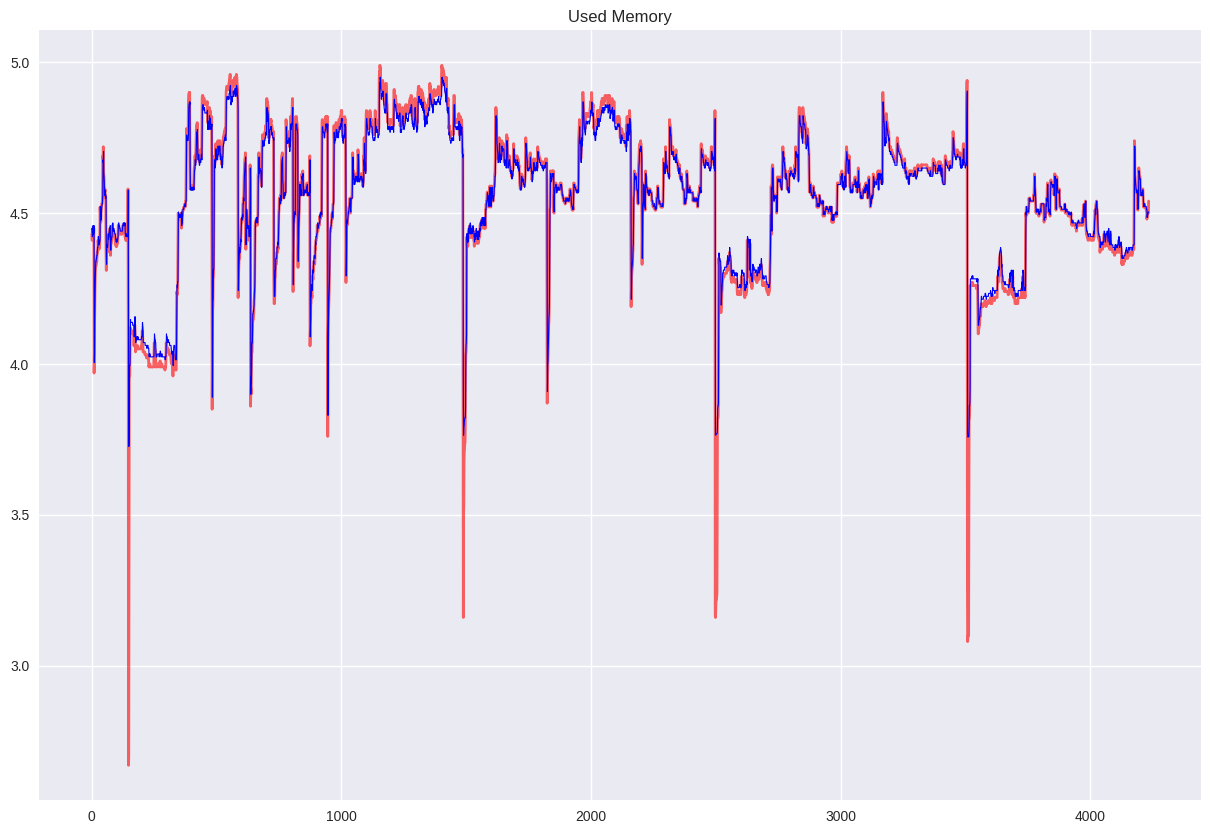

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 1, 1)
plt.plot(y_tr_ds[:, 0, index], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(y_tr_predict[:, 0, index], color = 'blue', linewidth=0.8)
plt.title(col)
plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_train_result.png')
plt.show()

# Predicción con set de testeo

In [ ]:
# plt.figure(figsize=(15, 10))
# plt.subplot(1, 1, 1)
# plt.plot(y_ts_ds[:, 0, 0], color = 'red', linewidth=2.0, alpha = 0.6)
# plt.plot(y_ts_predict[:, 0, 0], color = 'blue', linewidth=0.8)
# plt.title(col)
# plt.grid(True)
# plt.savefig(f'{col.replace("/", "_")}_test_result.png')
# plt.show()

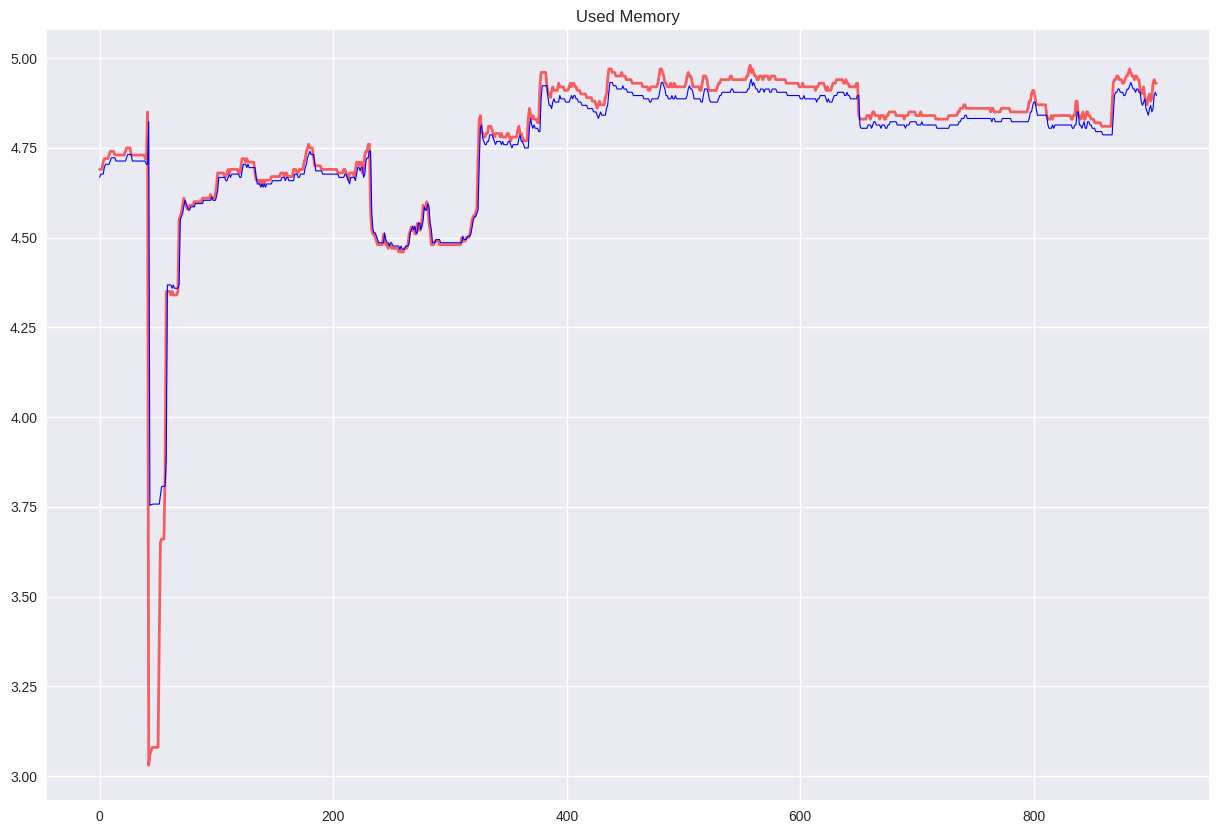

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 1, 1)
plt.plot(y_ts_ds[:, 0, index], color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(y_ts_predict[:, 0, index], color = 'blue', linewidth=0.8)
plt.title(col)
plt.grid(True)
plt.savefig(f'{col.replace("/", "_")}_test_result.png')
plt.show()

In [ ]:
y_ts_predict[:, 0, index]

array([4.6676154, 4.676735 , 4.676735 , 4.676735 , 4.694977 , 4.704099 ,
       4.704099 , 4.704099 , 4.704099 , 4.713222 , 4.7223454, 4.7223454,
       4.7223454, 4.7223454, 4.713222 , 4.713222 , 4.713222 , 4.713222 ,
       4.713222 , 4.713222 , 4.713222 , 4.713222 , 4.713222 , 4.7223454,
       4.731469 , 4.731469 , 4.731469 , 4.731469 , 4.713222 , 4.713222 ,
       4.713222 , 4.713222 , 4.713222 , 4.713222 , 4.713222 , 4.713222 ,
       4.713222 , 4.713222 , 4.713222 , 4.713222 , 4.704099 , 4.704099 ,
       4.8227096, 3.7536685, 3.7560139, 3.7567987, 3.757585 , 3.757585 ,
       3.757585 , 3.757585 , 3.757585 , 3.757585 , 3.7818766, 3.805913 ,
       3.8070877, 3.8070877, 3.8070877, 3.88038  , 4.368018 , 4.368018 ,
       4.368018 , 4.368018 , 4.3589597, 4.368018 , 4.3589597, 4.3589597,
       4.3589597, 4.3589597, 4.368018 , 4.5492125, 4.5583076, 4.567405 ,
       4.585608 , 4.6038194, 4.5947127, 4.585608 , 4.5765057, 4.5765057,
       4.585608 , 4.585608 , 4.585608 , 4.585608 , 

In [ ]:
pd.DataFrame({'real': y_ts_ds[:, 0, 0], 'predict': y_ts_predict[:, 0, 0]}).to_csv(f'result_{col}.csv')